/Users/paullucaci/Desktop/P20/ExperimentalMethod


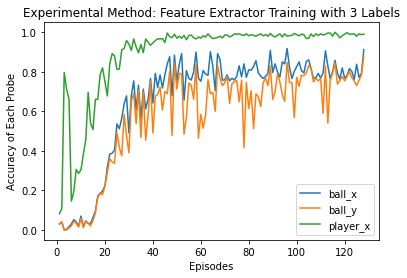

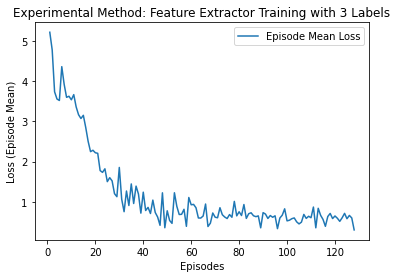

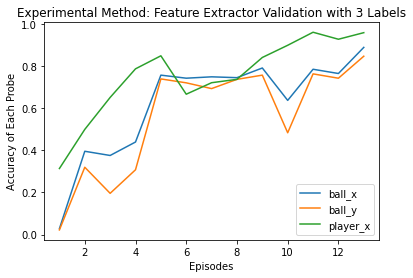

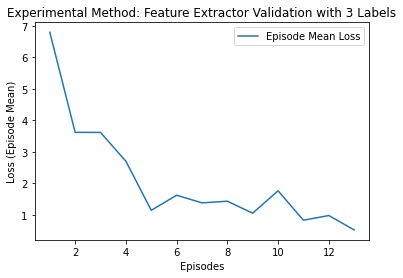

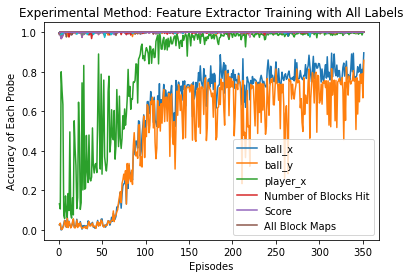

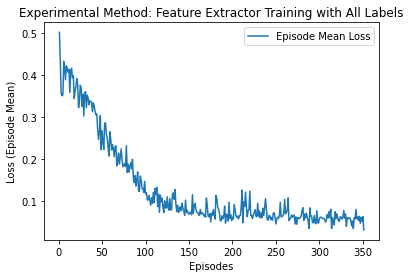

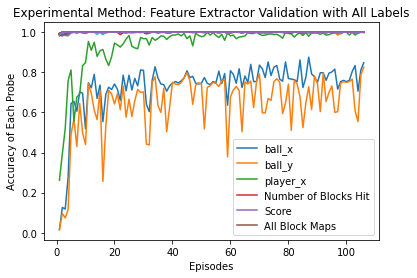

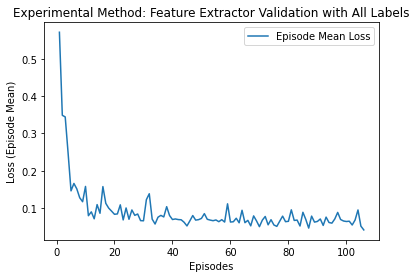

In [1]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/MyDrive/P20/ExperimentalMethod/

import matplotlib.pyplot as plt
import pandas as pd

def plot_performance(metrics_dict, title, legend):
    ax = plt.gca()
    probes_acc_df = {episode: metrics_dict[episode]["episodic_metrics_df"]['Accuracy'].to_dict() for episode in metrics_dict.keys()}
    probes_acc_df = pd.DataFrame.from_dict(probes_acc_df, orient='index')
    probes_acc_df.plot(title=title, legend=True, xlabel="Episodes", ylabel="Accuracy of Each Probe", ax=ax)
    ax.legend(["ball_x", "ball_y", "player_x", "Number of Blocks Hit", "Score", "All Block Maps"])
    plt.show()

    ax = plt.gca()
    episode_loss_df = {episode: {"episode_mean_loss": metrics_dict[episode]["episode_mean_loss"]} for episode in metrics_dict.keys()}
    episode_loss_df = pd.DataFrame.from_dict(episode_loss_df, orient='index')
    episode_loss_df.plot(title=title, legend=True, xlabel="Episodes", ylabel="Loss (Episode Mean)", ax=ax)
    ax.legend(["Episode Mean Loss"])
    plt.show()

saved_models = ["3-probes_breakout_supervised_encoder", "all-probes_breakout_supervised_encoder"]
training_episodic_metrics = pd.read_pickle("./metrics/breakout_supervised_training_metrics.pkl")
validation_episodic_metrics = pd.read_pickle("./metrics/breakout_supervised_validation_metrics.pkl")
for model in saved_models:
    if "all-probes" in model:
        title = "with All Labels"
        legend = False
    else:
        title = "with 3 Labels"
        legend = True
    plot_performance(training_episodic_metrics[model], title="Experimental Method: Feature Extractor Training "+title, legend=legend)
    plot_performance(validation_episodic_metrics[model], title="Experimental Method: Feature Extractor Validation "+title, legend=legend)

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

%cd /content/drive/MyDrive/P20/ExperimentalMethod/
!pip install git+git://github.com/mila-iqia/atari-representation-learning.git

!git clone https://github.com/openai/baselines.git
!cd baselines; git checkout 9ee399f; pip install .

!pip install gym["atari"]
!python -m atari_py.import_roms "./Atari-Roms"

import sys, os

In [ ]:
import gym

%cd /content/drive/MyDrive/P20/ExperimentalMethod/
from atariari.benchmark.wrapper import AtariARIWrapper
from baselines.common.atari_wrappers import WarpFrame

import pickle
import pandas as pd
import numpy as np

import torch
import torch.nn as nn

import matplotlib.pyplot as plt

global device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
### Adapted from https://github.com/mila-iqia/atari-representation-learning/blob/08165740a7688853c6315751003aa4dee9901073/README.md#L125
class BaseEncoder(nn.Module):
    # Network defined by the Deepmind paper (Mnih, et al., 2013)
    ## Modified variant
    def __init__(self, input_channels):
        super().__init__()
        self.input_channels = input_channels
        self.final_conv_size = 64 * 9 * 6
        self.cnn = nn.Sequential(
            nn.Conv2d(self.input_channels, 32, 8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, stride=2),
            nn.ReLU(),
            nn.Conv2d(128, 64, 3, stride=1),
            nn.ReLU()
        )

    def forward(self, inputs):
        x = self.cnn(inputs)
        x = x.view(x.size(0), -1)
        return x

def get_encoder(state_dict=None):
    base_encoder = BaseEncoder(input_channels=1).to(device)
    if state_dict is not None:
        base_encoder.load_state_dict(state_dict)
    return base_encoder

### Adapted from https://github.com/mila-iqia/atari-representation-learning/blob/08165740a7688853c6315751003aa4dee9901073/atariari/benchmark/probe.py#L22
class FullySupervisedLinearProbe(nn.Module):
    def __init__(self, final_enc_size, num_classes=256):
        super().__init__()
        self.final_enc_size = final_enc_size
        self.num_classes = num_classes
        self.probe = nn.Linear(in_features=self.final_enc_size, out_features=self.num_classes)

    def forward(self, feature_vec):
        return self.probe(feature_vec)

### Adapted from https://github.com/mila-iqia/atari-representation-learning/blob/08165740a7688853c6315751003aa4dee9901073/atariari/benchmark/probe.py#L69
def get_probes(final_conv_size, info, labels):
    return {k: FullySupervisedLinearProbe(final_enc_size=final_conv_size).to(device) for k in info['labels'].keys() if k in labels}

###############################################

def plot_performance(metrics_dict, title, legend):
    ax = plt.gca()
    probes_acc_df = {episode: metrics_dict[episode]["episodic_metrics_df"]['Accuracy'].to_dict() for episode in metrics_dict.keys()}
    probes_acc_df = pd.DataFrame.from_dict(probes_acc_df, orient='index')
    probes_acc_df.plot(title=title, legend=True, xlabel="Episodes", ylabel="Accuracy of Each Probe", ax=ax)
    ax.legend(["ball_x", "ball_y", "player_x", "Number of Blocks Hit", "Score", "All Block Maps"])
    plt.show()

    ax = plt.gca()
    episode_loss_df = {episode: {"episode_mean_loss": metrics_dict[episode]["episode_mean_loss"]} for episode in metrics_dict.keys()}
    episode_loss_df = pd.DataFrame.from_dict(episode_loss_df, orient='index')
    episode_loss_df.plot(title=title, legend=True, xlabel="Episodes", ylabel="Loss (Episode Mean)", ax=ax)
    ax.legend(["Episode Mean Loss"])
    plt.show()

def save_metrics(metrics_dict, metrics_filename):
    with open("./metrics/" + metrics_filename + ".pkl", "wb") as metrics_file:
        pickle.dump(metrics_dict, metrics_file)
    metrics_file.close()

def compute_accuracy(metrics_dict, label):
    return float(np.sum((torch.Tensor(metrics_dict['preds'][label]).numpy() == np.array(metrics_dict['target'][label]).astype(int))) / len(metrics_dict['target'][label]))

def do_epoch(env, random_state, episode, frames, accuracy_tensor, encoder, my_probes, optimizer, criterion, to_train):
    env.reset()

    episode_loss = []
    acc_metrics = {
        'preds': {probe: [] for probe in my_probes},
        'target': {probe: [] for probe in my_probes}
    }

    for frame in range(frames):
        optimizer.zero_grad()

        action = random_state.choice(4)
        state, reward, done, info = env.step(action)

        target = [info['labels'][probe] for probe in my_probes]
        target = torch.Tensor(target).long().to(device)
        for probe in my_probes: acc_metrics['target'][probe].append(info['labels'][probe])

        state = torch.unsqueeze(torch.Tensor(state).permute(2,0,1).to(device), dim=0)
        if to_train:
            features = encoder(state).to(device)
        else:
            features = encoder(state).detach().to(device)

        preds = torch.cat([my_probes[probe](features) for probe in my_probes], dim=0)

        for i, probe in enumerate(my_probes): acc_metrics['preds'][probe].append(torch.argmax(preds[i].detach()).cpu())

        loss = criterion(preds, target)
        loss.backward()
        optimizer.step()

        episode_loss.append(loss.item())

        if done:
            break

    for i, probe in enumerate(my_probes): accuracy_tensor[i] = compute_accuracy(acc_metrics, probe)
    episodic_metrics_df = pd.DataFrame(data=accuracy_tensor, index=list(my_probes.keys()), columns=['Accuracy'])
    episode_mean_loss = np.mean(episode_loss)

    print(
        f"Episode: {episode}\t #Frames: {len(episode_loss)}\n"
        f"Overall Episode Loss: {episode_mean_loss:.2f}",
        "\n------------\n",
        episodic_metrics_df, "\n"
    )
    return episodic_metrics_df, episode_mean_loss

def supervised_encoder_training(env, random_state, labels, frames, base_encoder, my_probes, optim, lr, wd, criterion, acc_tshold):
    params = list(base_encoder.parameters())
    for probe in my_probes:
        params += list(my_probes[probe].parameters())

    optimizer = optim(params, lr=lr, weight_decay=wd)

    base_encoder.train()
    for probe in my_probes: my_probes[probe].train()

    episodic_metrics = dict()
    accuracy_tensor = torch.zeros_like(torch.Tensor(range(len(my_probes))))
    episode = 0
    while not torch.all(accuracy_tensor > acc_tshold):
        episode += 1
        episodic_metrics_df, episode_mean_loss = do_epoch(env, random_state, episode, frames, accuracy_tensor, base_encoder, my_probes, optimizer, criterion, to_train=True)
        episodic_metrics[episode] = {"episodic_metrics_df": episodic_metrics_df, "episode_mean_loss": episode_mean_loss}
    return episodic_metrics

def supervised_encoder_validation(env, random_state, labels, frames, base_encoder, my_probes, optim, lr, wd, criterion, acc_tshold):
    params = []
    for probe in my_probes:
        params += list(my_probes[probe].parameters())

    optimizer = optim(params, lr=lr, weight_decay=wd)

    base_encoder.eval()
    for probe in my_probes: my_probes[probe].train()

    episodic_metrics = dict()
    accuracy_tensor = torch.zeros_like(torch.Tensor(range(len(my_probes))))
    episode = 0
    while not torch.all(accuracy_tensor > acc_tshold):
        episode += 1
        episodic_metrics_df, episode_mean_loss = do_epoch(env, random_state, episode, frames, accuracy_tensor, base_encoder, my_probes, optimizer, criterion, to_train=False)
        episodic_metrics[episode] = {"episodic_metrics_df": episodic_metrics_df, "episode_mean_loss": episode_mean_loss}
    return episodic_metrics

In [ ]:
### Environment and Hyperparameters

env = AtariARIWrapper(WarpFrame(gym.make('BreakoutNoFrameskip-v4'), width=160, height=210, grayscale=True))
env.reset(); ___, __, _, info = env.step(1);

optim = torch.optim.SGD
lr = 0.005
wd = 0.0005
criterion = nn.CrossEntropyLoss().to(device)

seed = 42
frames = 500

In [ ]:
## labels = list(['ball_x', 'ball_y', 'player_x']) ## Specify selected labels
## labels = list(info['labels'].keys()) ## Uncomment for all labels available
state_variables_sets = [list(['ball_x', 'ball_y', 'player_x'])] + [list(info['labels'].keys())]
saved_models = ["3-probes_breakout_supervised_encoder", "all-probes_breakout_supervised_encoder"]
training_episodic_metrics = dict()
validation_episodic_metrics = dict()

for state_variables_set, saved_model in zip(state_variables_sets, saved_models):
    ### Supervised Training ###
    base_encoder = get_encoder()
    my_probes = get_probes(final_conv_size=base_encoder.final_conv_size, info=info, labels=state_variables_set)

    env.seed(seed)
    random_state = np.random.RandomState(seed)
    training_episodic_metrics[saved_model] = supervised_encoder_training(env, random_state, state_variables_set, frames, base_encoder, my_probes, optim, lr, wd, criterion, acc_tshold=0.85)
    torch.save(base_encoder.state_dict(), "./models/" + saved_model + ".pt")

    ### Validation through Probe Training only ###
    base_encoder = get_encoder(state_dict=torch.load(open("./models/" + saved_model + ".pt", "rb")))
    my_probes = get_probes(final_conv_size=base_encoder.final_conv_size, info=info, labels=state_variables_set)

    env.seed(seed+1)
    random_state = np.random.RandomState(seed+1)
    validation_episodic_metrics[saved_model] = supervised_encoder_validation(env, random_state, state_variables_set, frames, base_encoder, my_probes, optim, lr, wd, criterion, acc_tshold=0.82)

save_metrics(training_episodic_metrics, metrics_filename="breakout_supervised_training_metrics")
save_metrics(validation_episodic_metrics, metrics_filename="breakout_supervised_validation_metrics")

Streaming output truncated to the last 5000 lines.
Episode: 333	 #Frames: 500
Overall Episode Loss: 0.06 
------------
                   Accuracy
ball_x               0.786
ball_y               0.682
player_x             0.998
blocks_hit_count     1.000
score                1.000
block_bit_map_0      1.000
block_bit_map_1      1.000
block_bit_map_2      1.000
block_bit_map_3      1.000
block_bit_map_4      1.000
block_bit_map_5      1.000
block_bit_map_6      1.000
block_bit_map_7      1.000
block_bit_map_8      1.000
block_bit_map_9      1.000
block_bit_map_10     1.000
block_bit_map_11     1.000
block_bit_map_12     1.000
block_bit_map_13     1.000
block_bit_map_14     1.000
block_bit_map_15     1.000
block_bit_map_16     1.000
block_bit_map_17     1.000
block_bit_map_18     1.000
block_bit_map_19     1.000
block_bit_map_20     1.000
block_bit_map_21     1.000
block_bit_map_22     1.000
block_bit_map_23     1.000
block_bit_map_24     1.000
block_bit_map_25     1.000
block_bit_map_26

In [ ]:
while True: pass